In [1]:
using Plots, Random, LinearAlgebra, Statistics, SparseArrays

# Prox of nonnegative regularizer

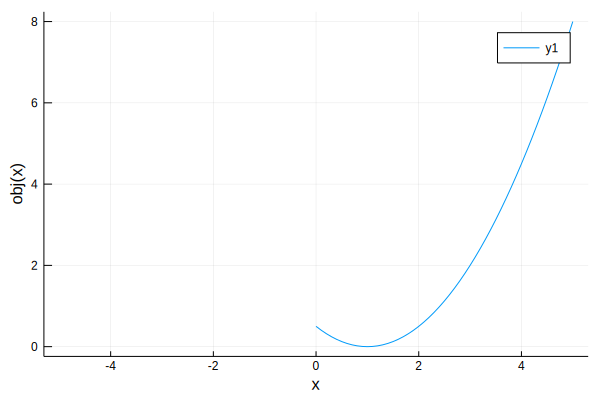

In [2]:
# prox of nonneg evaluated at z minimizes obj(x) = I(x>=0) + 1/2(x-z)^2

z = 1 # try out different values!
x = -5:.1:5
objx = [xi<0 ? Inf : 0 + 1/2*(xi-z)^2 for xi in x]
plot(x, objx)
xlabel!("x")
ylabel!("obj(x)") 

In [3]:
prox_nonneg(x) = max.(0,x)

prox_nonneg (generic function with 1 method)

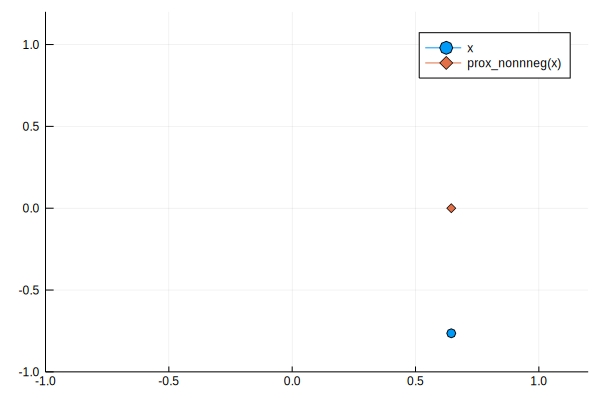

In [4]:
x = randn(2)
x /= norm(x)
px = prox_nonneg(x)

plot([x[1]],[x[2]],shape=:o,label="x")
plot!([px[1]],[px[2]],shape=:d,label="prox_nonnneg(x)")
xlims!((-1,1.2))
ylims!((-1,1.2))

# Prox of l1 regularizer

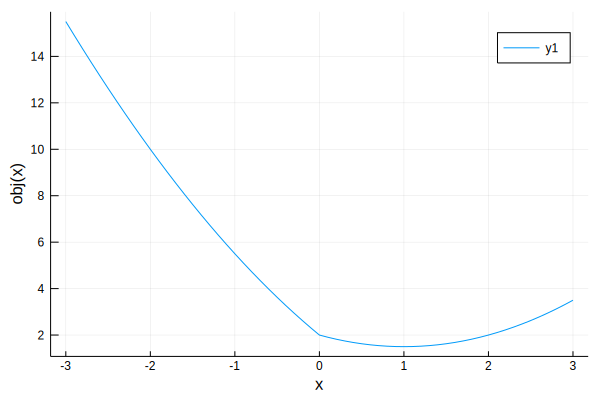

In [5]:
# prox of l1 evaluated at z minimizes |x| + 1/2(x-z)^2
z = 2
x = -3:.1:3
objx = [abs(xi) + 1/2*(xi-z)^2 for xi in x]
plot(x, objx)
xlabel!("x")
ylabel!("obj(x)")

In [6]:
function prox_l1(x::Number, alpha=1)
    if x > alpha
        return x-alpha
    elseif x < -alpha
        return x + alpha
    else
        return 0
    end
end

prox_l1 (generic function with 2 methods)

In [7]:
@show x = randn()
@show px = prox_l1(x);

x = randn() = 0.3458926564279414
px = prox_l1(x) = 0


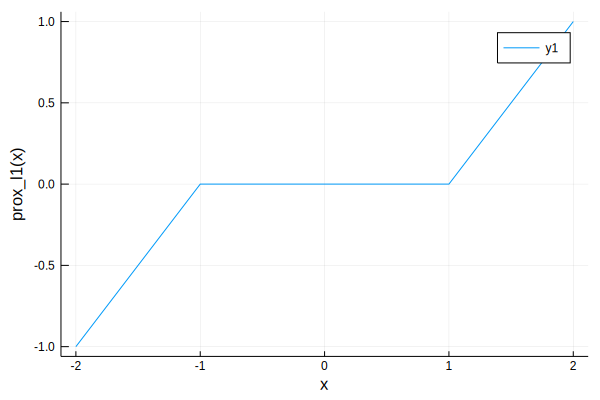

In [8]:
x = -2:.1:2
px = [prox_l1(xi) for xi in x]
plot(x, px)
xlabel!("x")
ylabel!("prox_l1(x)")

In [9]:
@show x = randn(2)
@show px = prox_l1(x);

x = randn(2) = [0.33347271568603226, -0.7522492246126943]


MethodError: MethodError: no method matching prox_l1(::Array{Float64,1})
Closest candidates are:
  prox_l1(!Matched::Number) at In[6]:2
  prox_l1(!Matched::Number, !Matched::Any) at In[6]:2

# proximal gradient method

$$\nabla \|Xw-y\|^2 = \nabla((Xw-y)^T (Xw-y)) = 2X^T(Xw-y)$$

In [10]:
# proximal gradient method for quadratic loss and nonnegative regularizer
function proxgrad_quad_nonneg(X, y; maxiters = 10, stepsize = 1, w = zeros(size(X,2)))
    w = zeros(size(X,2))
    objval = Float64[]
    for i=1:maxiters
        # gradient step
        g = 2X'*(X*w-y) # compute quadratic gradient
        z = w - stepsize*g
        # prox step
        w = prox_nonneg(z)
        # record objective value
        push!(objval, norm(X*w-y)^2 + any(w<0) ? Inf : 0)
    end
    return w, objval
end

proxgrad_quad_nonneg (generic function with 1 method)

In [11]:
# proximal gradient method for quadratic loss and l1 regularizer
function proxgrad_quad_l1(X, y; maxiters = 10, stepsize = 1., λ = 1., w = zeros(size(X,2)))
    objval = Float64[]
    for i=1:maxiters
        # gradient step
        g = 2X'*(X*w-y) # compute quadratic gradient
        z = w - stepsize*g
        # prox step
        myprox(z) = prox_l1(z, stepsize*λ)
        w = myprox.(z)
        # record objective value
        push!(objval, norm(X*w-y)^2 + norm(w,1))
    end
    return w, objval
end

proxgrad_quad_l1 (generic function with 1 method)

let's solve the problem $$\text{minimize} \quad (y-w)^2 + |w|$$

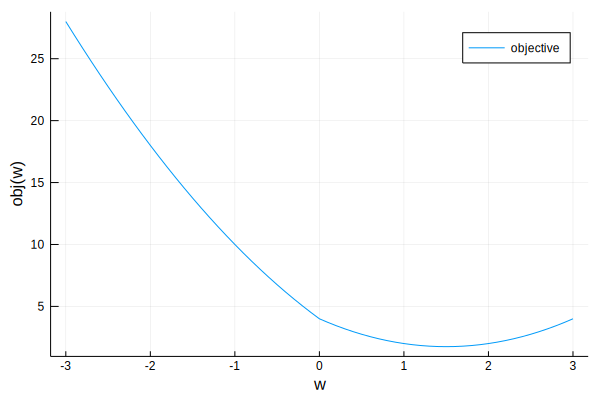

In [12]:
y = 2
wvec = -3:.1:3
objwvec = [(wi-y)^2 + abs(wi) for wi in wvec]
plot(wvec, objwvec, label="objective")
xlabel!("w")
ylabel!("obj(w)")

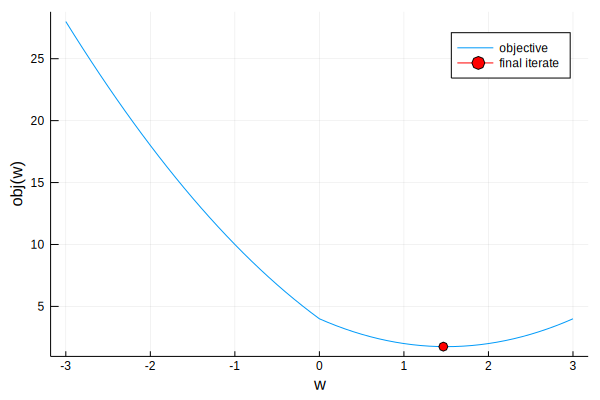

In [13]:
w = [-2]
X, y = ones(1,1), 2*ones(1)
w, obj = proxgrad_quad_l1(X, y; maxiters = 20, stepsize = .1, w = w)

plot(wvec, objwvec, label="objective")
xlabel!("w")
ylabel!("obj(w)")
plot!([w], [obj[end]], color=:red, shape=:o, label="final iterate")

In [14]:
obj

20-element Array{Float64,1}:
 10.709999999999997 
  6.0443999999999996
  4.0               
  3.1899999999999995
  2.6715999999999998
  2.3398239999999997
  2.1274873599999995
  1.9915919104      
  1.904618822656    
  1.84895604649984  
  1.8133318697598977
  1.7905323966463347
  1.7759407338536541
  1.7666020696663387
  1.760625324586457 
  1.7568002077353324
  1.7543521329506127
  1.7527853650883922
  1.751782633656571 
  1.7511408855402055

# Introduce LowRankModels

In [15]:
using LowRankModels

In [16]:
# loss function
loss = QuadLoss()

QuadLoss(1.0, RealDomain())

In [17]:
# regularizers
lambda = 1

nonneg = NonNegConstraint()
l1 = OneReg(lambda)
l2 = QuadReg(lambda)

QuadReg(1.0)

In [18]:
# the quad loss returns the sum of square differences between its first and second argument
evaluate(loss, 2., 3.)

1.0

In [19]:
evaluate(3*loss, 2., 3.)

3.0

In [20]:
evaluate(1/2*loss, [2., 2.], [3., 3.])

1.0

In [21]:
# can also evaluate the gradient wrt the first argument
grad(loss, 2., 0.)

4.0

In [22]:
grad(loss, 0., 2.)

-4.0

In [23]:
grad(L1Loss(), 2., 0.)

1.0

In [24]:
# can evaluate the proximal operator of the regularizer
prox(nonneg, [-1, 1])

2-element Array{Int64,1}:
 0
 1

In [25]:
# can evaluate the proximal operator of lambda times the regularizer
λ = .01
prox(l1, 1, λ)

0.99

In [26]:
# chain rule: 
# gradient of ||Xw - y||^2 wrt w is X' * <gradient of ||z-y||^2 wrt z>, 
# where z = X*w

In [27]:
import LowRankModels: evaluate, grad
evaluate(loss::Loss, X::Array{Float64,2}, w, y) = evaluate(loss, X*w, y)
grad(loss::Loss, X::Array{Float64,2}, w, y) = X'*grad(loss, X*w, y)

grad (generic function with 19 methods)

In [28]:
# proximal gradient method
function proxgrad(loss, reg, X, y; maxiters = 10, stepsize = 1)
    w = zeros(size(X,2))
    objval = Float64[]
    for i=1:maxiters
        # gradient step
        g = grad(loss, X, w, y)
        z = w - stepsize*g
        # prox step
        w = prox(reg, z, stepsize)
        # record objective value
        push!(objval, evaluate(loss, X, w, y) + evaluate(reg, w))
    end
    return w, objval
end

proxgrad (generic function with 1 method)

In [29]:
# proximal gradient method
function proxgrad(loss::Loss, reg::Regularizer, X, y;
                  maxiters::Int = 10, stepsize::Number = 1., 
                  ch::ConvergenceHistory = ConvergenceHistory("proxgrad"))
    w = zeros(size(X,2))
    for t=1:maxiters
        t0 = time()
        # gradient step
        g = grad(loss, X, w, y)
        w = w - stepsize*g
        # prox step
        w = prox(reg, w, stepsize)
        # record objective value
        update_ch!(ch, time() - t0, obj = evaluate(loss, X, w, y) + evaluate(reg, w))
    end
    return w
end

proxgrad (generic function with 2 methods)

In [44]:
Random.seed!(0)
X, y = rand(6,3), rand(6);

ch.objective = [0.6555863318320578, 0.5465126243857916, 0.4872933063866245, 0.4510021704725271, 0.4286309667876147, 0.41475126065249646, 0.4072832551873474, 0.4029358868595502, 0.39954012957851204, 0.39679042340686554, 0.39455627373061486, 0.3927404460838273, 0.39126457115114677, 0.39006500100830993, 0.38909000722688153, 0.3882975459431014, 0.38765344451439054, 0.3871299278971893, 0.38670442092534596, 0.3863585748201059, 0.38607747595116926, 0.3858490027287731, 0.38566330289458445, 0.38551236867106353, 0.3853895063546891, 0.3852869867733054, 0.38519866811832376, 0.3851208004704724, 0.3850509762297287, 0.38498761265366577, 0.3849296372204586, 0.3848762955657795, 0.3848270340551772, 0.3847814278191293, 0.3847391364926857, 0.38469987684914964, 0.38466340574588964, 0.38462950937423657, 0.3845979963720976, 0.38456869331158566, 0.38454144165452375, 0.3845160956221497, 0.3844925206405796, 0.38447059215470114, 0.38445019468304786, 0.3844312210349158, 0.38441357164071976, 0.3843971539647434, 0.

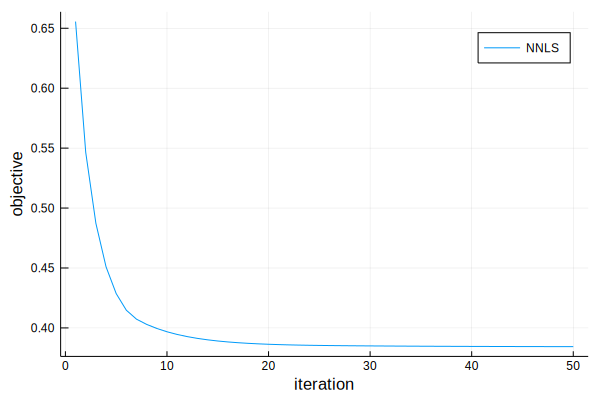

In [48]:
ch = ConvergenceHistory("NNLS")
w = proxgrad(QuadLoss(), NonNegConstraint(), X, y; 
             stepsize=.1, maxiters=50,
             ch = ch)

@show ch.objective
plot(ch.objective, label="NNLS")
xlabel!("iteration")
ylabel!("objective")

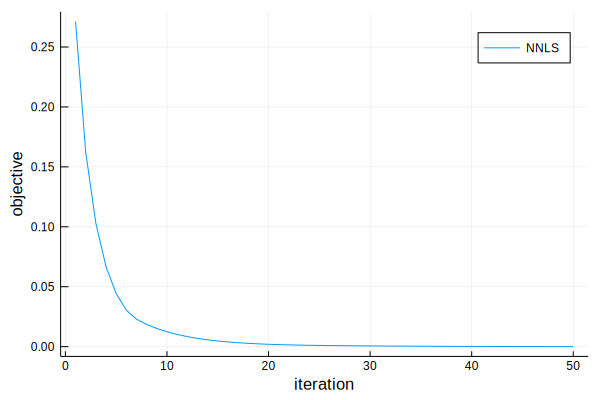

In [51]:
plot(ch.objective .- ch.objective[end], label="NNLS") # try semilog
xlabel!("iteration")
ylabel!("objective")

# Let's generate some more data and test out these models

In [52]:
function generate_data(n, w)
    X = randn(n,length(w))
    y = X*w
    return X, y
end

function generate_noisy_data(n, w)
    X = randn(n,length(w))
    y = X*w + .1*randn(n)
    return X, y
end

generate_noisy_data (generic function with 1 method)

# let's repeat what we did in the regularized regression notebook, using our nifty proximal gradient method

compare different kinds of regularized regression

In [53]:
function ridge_regression(X,y; λ=1, kwargs...)
    w = proxgrad(QuadLoss(), λ*QuadReg(), X, y; kwargs...)
    return w
end

ridge_regression (generic function with 1 method)

In [54]:
function nnls(X,y; kwargs...)
    w = proxgrad(QuadLoss(), NonNegConstraint(), X, y; kwargs...)
    return w
end

nnls (generic function with 1 method)

In [55]:
function lasso(X,y; λ=1, kwargs...)
    w = proxgrad(QuadLoss(), λ*OneReg(), X, y; kwargs...)
    return w
end

lasso (generic function with 1 method)

In [85]:
# generate data

d = 30
w_randn = randn(d)
w_sparse = sprandn(d, .5)
w_pos = sprand(d, .5);

w = w_sparse

X, y = generate_noisy_data(30, w)

([1.0128767749639944 -0.37211464760105983 … -0.804911594048133 0.2658042055716681; -0.8231995539651362 -0.17926444961957794 … 0.8918311947894791 -0.16231446550112358; … ; -0.08225055972107471 -0.49713427254111775 … 1.4619132948677271 -0.07259625657298698; 1.305192721883139 -0.36753565823204826 … -1.380178491056961 0.2728323566369616], [-1.6242238338203916, 0.062046796502146916, 9.245792644172832, -0.40532508654171884, 2.768598359943367, 4.571270776007058, -2.0942050283626252, 4.416424079241278, 4.173629649129853, -1.3799157945618228  …  3.8182596468117205, -0.4351136532062966, -0.6795903493875873, 0.79884115643169, -3.0115329335289514, 0.14992808384645664, -0.8205995583081922, 0.13499232017752433, 1.8328210105982805, -6.660459283368125])

In [86]:
maxiters = 10000
stepsize = .1/norm(X)

w_ridge = ridge_regression(X,y, maxiters=maxiters, stepsize=stepsize)
w_nonneg = nnls(X,y, maxiters=maxiters, stepsize=stepsize)
w_lasso = lasso(X,y, maxiters=maxiters, stepsize=stepsize);

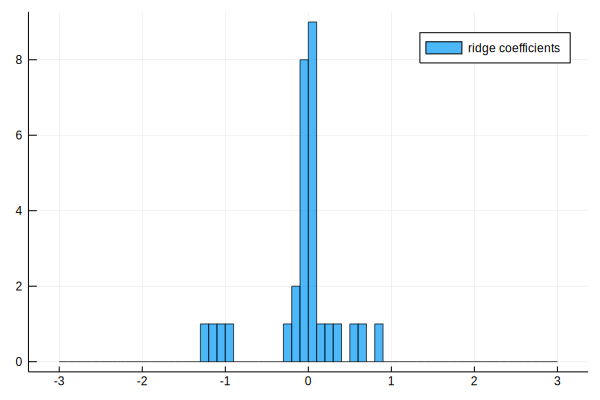

In [87]:
histogram(w_ridge, label="ridge coefficients", bins=-3:.1:3, alpha=.7)

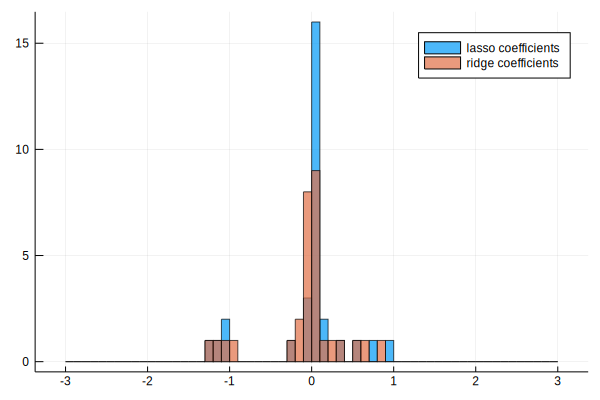

In [88]:
histogram(w_lasso, label="lasso coefficients", bins=-3:.1:3, alpha=.7)
histogram!(w_ridge, label="ridge coefficients", bins=-3:.1:3, alpha=.7)

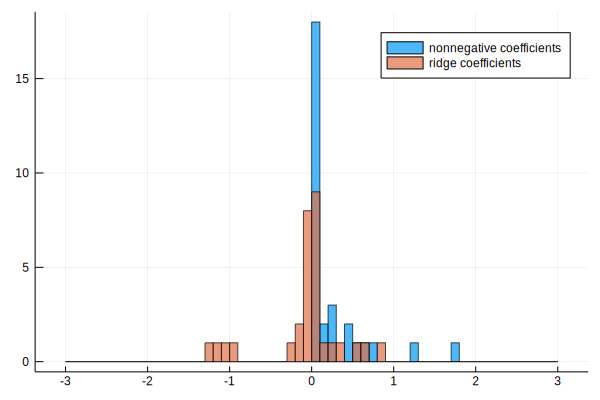

In [89]:
histogram(w_nonneg, label="nonnegative coefficients", bins=-3:.1:3, alpha=.7)
histogram!(w_ridge, label="ridge coefficients", bins=-3:.1:3, alpha=.7)

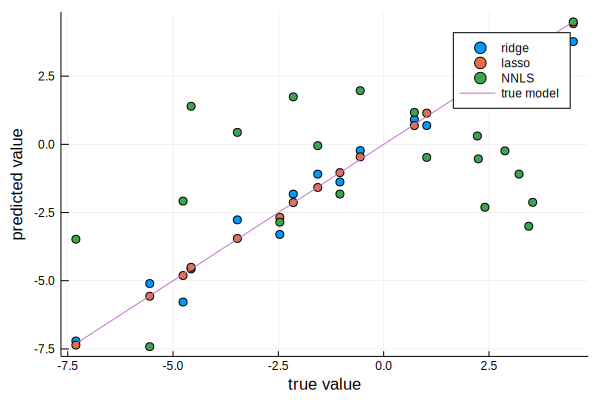

In [90]:
# which fits data best?
Xtest,ytest = generate_data(20,w)

scatter(ytest,Xtest*w_ridge,label="ridge")
scatter!(ytest,Xtest*w_lasso,label="lasso")
scatter!(ytest,Xtest*w_nonneg,label="NNLS")
plot!(ytest,ytest,label="true model")
xlabel!("true value")
ylabel!("predicted value")

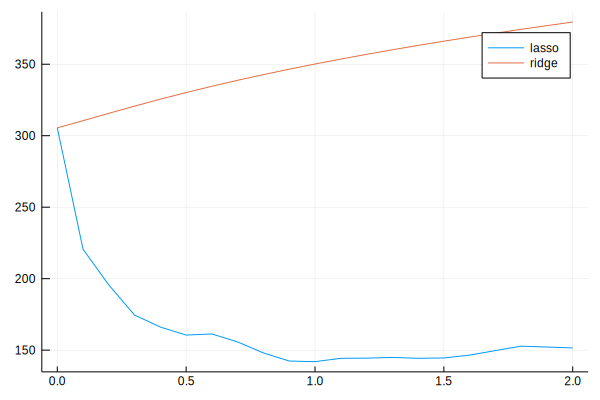

In [102]:
# cross validate over lambda
Random.seed!(1)

w = randn(40)
X,y = generate_noisy_data(30, w)
Xtest,ytest = generate_noisy_data(30, w)

maxiters = 10000
stepsize = .1/norm(X)

ridge_error = Float64[]
lasso_error = Float64[]
λs = 0:.1:2
for λ in λs
    w = ridge_regression(X,y, λ=λ, maxiters=maxiters, stepsize=stepsize)
    push!(ridge_error, sum((ytest - Xtest*w).^2))
    w = lasso(X,y, λ=λ, maxiters=maxiters, stepsize=stepsize);
    push!(lasso_error, sum((ytest - Xtest*w).^2))
end
plot(λs, lasso_error, label="lasso")
plot!(λs, ridge_error, label="ridge")